# 텍스트에서 질문-대답 쌍 생성하기

*Note: 라이브러리 버전 차이로 책의 결과와 다를 수 있습니다.*

번역서 깃허브에는 `glove.6B.100d.trimmed.txt` 파일이 포함되어 있습니다. 이 파일을 직접 만들려면 [GloVe 웹사이트](https://nlp.stanford.edu/projects/glove/)에서 `glove.6B.zip` 파일을 다운로드한 후 `glove.6B.100d.txt` 파일을 `data/glove` 폴더로 옮기세요. 그다음 다음 명령을 실행하여 `glove.6B.100d.trimmed.txt` 파일을 만들 수 있습니다.

In [1]:
#!python ./utils/write.py

NewsQA 데이터를 직접 만들려면 책에 실린 안내 사항을 참고하세요.

번역서는 만들어진 NewsQA 데이터를 [다운로드](https://bit.ly/3pYhc9P)할 수 있도록 제공합니다. 이 파일을 다운로드한 후 `data/qa` 폴더에 압축을 푸세요.

In [2]:
import importlib
import os

from keras.layers import Input, Embedding, GRU, Bidirectional, Dense, Lambda
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
import keras.backend as K
from keras.utils import plot_model

import numpy as np
import random
import pickle as pkl

from utils.write import training_data, test_data, collapse_documents, expand_answers, _read_data, glove

import matplotlib.pyplot as plt

Using TensorFlow backend.
/home/haesun/github/GDL_code/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/haesun/github/GDL_code/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/haesun/github/GDL_code/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/haesun/github/GDL_co

In [3]:
# run params
SECTION = 'write'
RUN_ID = '0001'
DATA_NAME = 'qa'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

# 데이터 적재

In [4]:
training_data_gen = training_data()
# training_data_gen = [next(training_data_gen)]
test_data_gen = test_data()

In [5]:
t = next(training_data_gen)

In [6]:
idx = 0

print('document_tokens\n', t['document_tokens'][idx])
print('\n')
print('question_input_tokens\n', t['question_input_tokens'][idx])
print('\n')
print('answer_masks\n', t['answer_masks'][idx])
print('\n')
print('answer_labels\n', t['answer_labels'][idx])
print('\n')
print('question_output_tokens\n', t['question_output_tokens'][idx])

document_tokens
 [   1    5 3508    1 4601    1   66 6786    1   17   11    1  745    1
    6   26   27    1  282   16    4 2386 1567    7   11    1  446   10
    1    5 3508    5   21    1   67  692 2779    9 4084    4 1138    1
   13   11  222    7   27 3487 2461    6 6786    1 2540  586    4 2609
    1   21   18    1    8  306   16    1  315    6   29 1167   16    4
  217  689    1 1167   16    4  247    6   13    1   70    9 4533  117
  284    5   15   12  191    1    5   28   21  210    6  133   83  362
    5    1   18 2604   11 9755  172  370    9  818   11 5697   60    1
 5893 1618    8  306   16 2452    1    6   15  363    5    1   18    1
    6   21 1289   11    1    1   13   81 6012    9    1    8 6350   11
 2538    8  306   16  180    1  315   66  120    8  252   84   21   95
    6  719   50    5   21 3792   27  881    1    9    1   11    1    8
    4 4256    1   15   19    5   29   38 1882  970   16 1350    1  315
    6   28   29   13   11  591    1    1    5   42   18 3473

In [7]:
# GloVe

VOCAB_SIZE = glove.shape[0]
EMBEDDING_DIMENS = glove.shape[1]

print('GLOVE')
print('VOCAB_SIZE: ', VOCAB_SIZE)
print('EMBEDDING_DIMENS: ', EMBEDDING_DIMENS)

GRU_UNITS = 100

GLOVE
VOCAB_SIZE:  9984
EMBEDDING_DIMENS:  100


# 파라미터

In [8]:
MAX_DOC_SIZE = None
MAX_ANSWER_SIZE = None
MAX_Q_SIZE = None

# 모델 생성

In [9]:
document_tokens = Input(shape=(MAX_DOC_SIZE,), name="document_tokens")

embedding = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBEDDING_DIMENS, weights=[glove], mask_zero = True, name = 'embedding')
document_emb = embedding(document_tokens)

answer_outputs = Bidirectional(GRU(GRU_UNITS, return_sequences=True), name = 'answer_outputs')(document_emb)
answer_tags = Dense(2, activation = 'softmax', name = 'answer_tags')(answer_outputs)

encoder_input_mask = Input(shape=(MAX_ANSWER_SIZE, MAX_DOC_SIZE), name="encoder_input_mask")
encoder_inputs = Lambda(lambda x: K.batch_dot(x[0], x[1]), name="encoder_inputs")([encoder_input_mask, answer_outputs])
encoder_cell = GRU(2 * GRU_UNITS, name = 'encoder_cell')(encoder_inputs)

decoder_inputs = Input(shape=(MAX_Q_SIZE,), name="decoder_inputs")
decoder_emb = embedding(decoder_inputs)
decoder_emb.trainable = False
decoder_cell = GRU(2 * GRU_UNITS, return_sequences = True, name = 'decoder_cell')
decoder_states = decoder_cell(decoder_emb, initial_state = [encoder_cell])

decoder_projection = Dense(VOCAB_SIZE, name = 'decoder_projection', activation = 'softmax', use_bias = False)
decoder_outputs = decoder_projection(decoder_states)

total_model = Model([document_tokens, decoder_inputs, encoder_input_mask], [answer_tags, decoder_outputs])
plot_model(total_model, to_file='model.png',show_shapes=True)

W0917 11:08:19.329666 140483760518976 deprecation_wrapper.py:119] From /home/haesun/github/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0917 11:08:19.341881 140483760518976 deprecation_wrapper.py:119] From /home/haesun/github/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0917 11:08:19.347920 140483760518976 deprecation_wrapper.py:119] From /home/haesun/github/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0917 11:08:19.348447 140483760518976 deprecation_wrapper.py:119] From /home/haesun/github/GDL_code/env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. P

![QA 모델](model.png)

In [10]:
decoder_emb.shape

TensorShape([Dimension(None), Dimension(None), Dimension(100)])

In [11]:
answer_model = Model(document_tokens, [answer_tags])
decoder_initial_state_model = Model([document_tokens, encoder_input_mask], [encoder_cell])

In [12]:
total_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
document_tokens (InputLayer)    (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    998400      document_tokens[0][0]            
                                                                 decoder_inputs[0][0]             
__________________________________________________________________________________________________
answer_outputs (Bidirectional)  (None, None, 200)    120600      embedding[0][0]                  
__________________________________________________________________________________________________
encoder_input_mask (InputLayer) (None, None, None)   0                                            
__________

In [13]:
#### 예측을 위한 모델 ####

decoder_inputs_dynamic = Input(shape=(1,), name="decoder_inputs_dynamic")
decoder_emb_dynamic = embedding(decoder_inputs_dynamic)
decoder_init_state_dynamic = Input(shape=(2 * GRU_UNITS,), name = 'decoder_init_state_dynamic') #the embedding of the previous word
decoder_states_dynamic = decoder_cell(decoder_emb_dynamic, initial_state = [decoder_init_state_dynamic])
decoder_outputs_dynamic = decoder_projection(decoder_states_dynamic)

question_model = Model([decoder_inputs_dynamic, decoder_init_state_dynamic], [decoder_outputs_dynamic, decoder_states_dynamic])

In [14]:
#### 모델 컴파일 ####

opti = Adam(lr=0.001)
total_model.compile(loss=['sparse_categorical_crossentropy', 'sparse_categorical_crossentropy']
                    , optimizer=opti
                    , loss_weights = [1,1]) 

W0917 11:08:20.765857 140483760518976 deprecation_wrapper.py:119] From /home/haesun/github/GDL_code/env/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



# 모델 훈련

*Note: 이 훈련은 오랜 시간이 걸립니다. 적절히 에포크 횟수를 조절하세요. 번역서 깃허브는 훈련된 가중치를 제공하므로 훈련 과정을 건너 뛰고 06_03_qa_analysis.ipynb를 바로 실행할 수 있습니다.*

In [15]:
training_loss_history = []
test_loss_history = []

EPOCHS = 2000
start_epoch = 1

In [16]:
for epoch in range(start_epoch, start_epoch + EPOCHS + 1):
    print("에포크 {0}".format(epoch))
    
    for i, batch in enumerate(training_data()):
        
        val_batch = next(test_data_gen, None)
        
        if val_batch is None:
            test_data_gen = test_data()
            val_batch = next(test_data_gen, None)
            
        training_loss = total_model.train_on_batch(
            [batch['document_tokens'], batch['question_input_tokens'], batch['answer_masks']]
            , [np.expand_dims(batch['answer_labels'], axis = -1), np.expand_dims(batch['question_output_tokens'], axis = -1)]
        )
        
        test_loss = total_model.test_on_batch(
            [val_batch['document_tokens'], val_batch['question_input_tokens'], val_batch['answer_masks']]
            , [np.expand_dims(val_batch['answer_labels'], axis = -1), np.expand_dims(val_batch['question_output_tokens'], axis = -1)]
        )
        
        training_loss_history.append(training_loss)
        test_loss_history.append(test_loss)
    
    if epoch % 100 == 0:
        print("{}: 훈련 손실: {} | 테스트 손실: {}".format(i, training_loss, test_loss))    
        total_model.save_weights(os.path.join(RUN_FOLDER, 'weights/weights_{}.h5'.format(epoch)))

에포크 1
에포크 2
에포크 3
에포크 4
에포크 5
에포크 6
에포크 7
에포크 8
에포크 9
에포크 10
에포크 11
에포크 12
에포크 13
에포크 14
에포크 15
에포크 16
에포크 17
에포크 18
에포크 19
에포크 20
에포크 21
에포크 22
에포크 23
에포크 24
에포크 25
에포크 26
에포크 27
에포크 28
에포크 29
에포크 30
에포크 31
에포크 32
에포크 33
에포크 34
에포크 35
에포크 36
에포크 37
에포크 38
에포크 39
에포크 40
에포크 41
에포크 42
에포크 43
에포크 44
에포크 45
에포크 46
에포크 47
에포크 48
에포크 49
에포크 50
에포크 51
에포크 52
에포크 53
에포크 54
에포크 55
에포크 56
에포크 57
에포크 58
에포크 59
에포크 60
에포크 61
에포크 62
에포크 63
에포크 64
에포크 65
에포크 66
에포크 67
에포크 68
에포크 69
에포크 70
에포크 71
에포크 72
에포크 73
에포크 74
에포크 75
에포크 76
에포크 77
에포크 78
에포크 79
에포크 80
에포크 81
에포크 82
에포크 83
에포크 84
에포크 85
에포크 86
에포크 87
에포크 88
에포크 89
에포크 90
에포크 91
에포크 92
에포크 93
에포크 94
에포크 95
에포크 96
에포크 97
에포크 98
에포크 99
524: 훈련 손실: [0.74277806, 0.11624601, 0.6265321] | 테스트 손실: [7.929379, 0.115753874, 7.8136253]
에포크 100
에포크 101
에포크 102
에포크 103
에포크 104
에포크 105
에포크 106
에포크 107
에포크 108
에포크 109
에포크 110
에포크 111
에포크 112
에포크 113
에포크 114
에포크 115
에포크 116
에포크 117
에포크 118
에포크 119
에포크 120
에포크 121
에포크 122
에포크 123
에포크 124
에포크 125
에포크 126
에포크 127

에포크 935
에포크 936
에포크 937
에포크 938
에포크 939
에포크 940
에포크 941
에포크 942
에포크 943
에포크 944
에포크 945
에포크 946
에포크 947
에포크 948
에포크 949
에포크 950
에포크 951
에포크 952
에포크 953
에포크 954
에포크 955
에포크 956
에포크 957
에포크 958
에포크 959
에포크 960
에포크 961
에포크 962
에포크 963
에포크 964
에포크 965
에포크 966
에포크 967
에포크 968
에포크 969
에포크 970
에포크 971
에포크 972
에포크 973
에포크 974
에포크 975
에포크 976
에포크 977
에포크 978
에포크 979
에포크 980
에포크 981
에포크 982
에포크 983
에포크 984
에포크 985
에포크 986
에포크 987
에포크 988
에포크 989
에포크 990
에포크 991
에포크 992
에포크 993
에포크 994
에포크 995
에포크 996
에포크 997
에포크 998
에포크 999
523: 훈련 손실: [0.2228032, 0.06412412, 0.15867908] | 테스트 손실: [8.83815, 0.55715764, 8.2809925]
에포크 1000
에포크 1001
에포크 1002
에포크 1003
에포크 1004
에포크 1005
에포크 1006
에포크 1007
에포크 1008
에포크 1009
에포크 1010
에포크 1011
에포크 1012
에포크 1013
에포크 1014
에포크 1015
에포크 1016
에포크 1017
에포크 1018
에포크 1019
에포크 1020
에포크 1021
에포크 1022
에포크 1023
에포크 1024
에포크 1025
에포크 1026
에포크 1027
에포크 1028
에포크 1029
에포크 1030
에포크 1031
에포크 1032
에포크 1033
에포크 1034
에포크 1035
에포크 1036
에포크 1037
에포크 1038
에포크 1039
에포크 1040
에포크 1041
에포크 1042
에포

에포크 1771
에포크 1772
에포크 1773
에포크 1774
에포크 1775
에포크 1776
에포크 1777
에포크 1778
에포크 1779
에포크 1780
에포크 1781
에포크 1782
에포크 1783
에포크 1784
에포크 1785
에포크 1786
에포크 1787
에포크 1788
에포크 1789
에포크 1790
에포크 1791
에포크 1792
에포크 1793
에포크 1794
에포크 1795
에포크 1796
에포크 1797
에포크 1798
에포크 1799
523: 훈련 손실: [0.14383121, 0.044373415, 0.09945779] | 테스트 손실: [9.0112095, 0.8453905, 8.165819]
에포크 1800
에포크 1801
에포크 1802
에포크 1803
에포크 1804
에포크 1805
에포크 1806
에포크 1807
에포크 1808
에포크 1809
에포크 1810
에포크 1811
에포크 1812
에포크 1813
에포크 1814
에포크 1815
에포크 1816
에포크 1817
에포크 1818
에포크 1819
에포크 1820
에포크 1821
에포크 1822
에포크 1823
에포크 1824
에포크 1825
에포크 1826
에포크 1827
에포크 1828
에포크 1829
에포크 1830
에포크 1831
에포크 1832
에포크 1833
에포크 1834
에포크 1835
에포크 1836
에포크 1837
에포크 1838
에포크 1839
에포크 1840
에포크 1841
에포크 1842
에포크 1843
에포크 1844
에포크 1845
에포크 1846
에포크 1847
에포크 1848
에포크 1849
에포크 1850
에포크 1851
에포크 1852
에포크 1853
에포크 1854
에포크 1855
에포크 1856
에포크 1857
에포크 1858
에포크 1859
에포크 1860
에포크 1861
에포크 1862
에포크 1863
에포크 1864
에포크 1865
에포크 1866
에포크 1867
에포크 1868
에포크 1869
에포크 1870
에포크 187

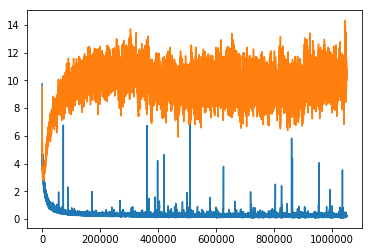

In [17]:
#### 손실 그래프 ####

plt.plot(np.array(training_loss_history)[:,0])
plt.plot(np.array(test_loss_history)[:,0])
plt.show()
        
pkl.dump([training_loss_history, test_loss_history], open(os.path.join(RUN_FOLDER, 'weights/histories.pkl'), 'wb'))